Import Libraries

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage





Load Dataset

In [31]:
df = pd.read_excel("EastWestAirlines.xlsx",sheet_name='data')



Data Preprocessing

In [32]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Impute numeric
df_numeric = df[numeric_cols].copy()
if not df_numeric.empty:
    num_imputer = SimpleImputer(strategy="mean")
    df_numeric = pd.DataFrame(num_imputer.fit_transform(df_numeric), columns=numeric_cols)

# Impute categorical
df_categorical = df[categorical_cols].copy()
if not df_categorical.empty:
    cat_imputer = SimpleImputer(strategy="most_frequent")
    df_categorical = pd.DataFrame(cat_imputer.fit_transform(df_categorical), columns=categorical_cols)

# Combine back
if not df_categorical.empty and not df_numeric.empty:
    df_imputed = pd.concat([df_numeric, df_categorical], axis=1)
elif not df_numeric.empty:
    df_imputed = df_numeric.copy()
else:
    df_imputed = df_categorical.copy()

# Encode categoricals
df_encoded = pd.get_dummies(df_imputed, drop_first=True)

# Scale
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)

EDA

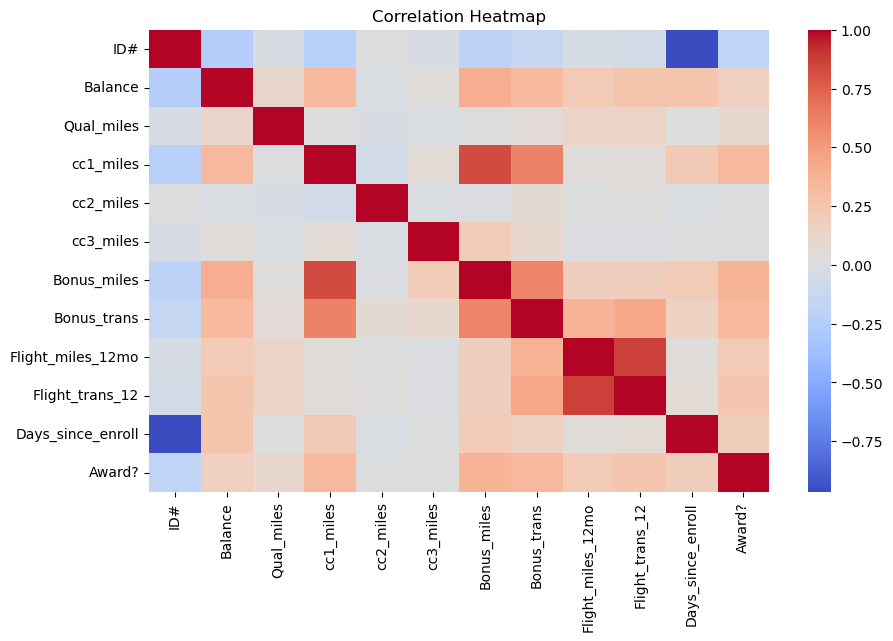

In [33]:
plt.figure(figsize=(10,6))
sns.heatmap(df_encoded.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

KMeans

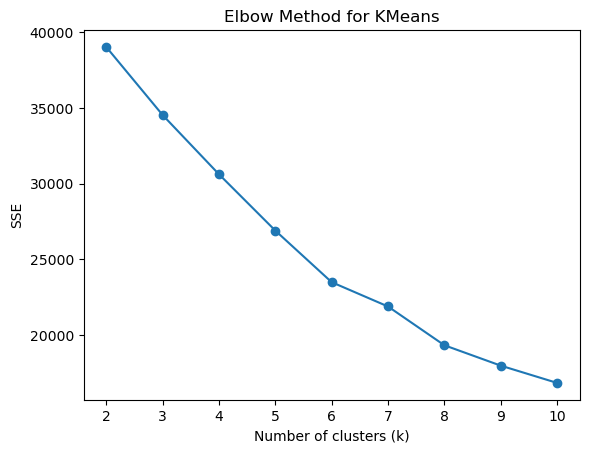

KMeans Silhouette Score: 0.2391100182603037


In [34]:
sse = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(2,11), sse, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.title("Elbow Method for KMeans")
plt.show()

# Fit KMeans with chosen k (example k=5)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df_scaled)
print("KMeans Silhouette Score:", silhouette_score(df_scaled, kmeans_labels))


Hierarchical

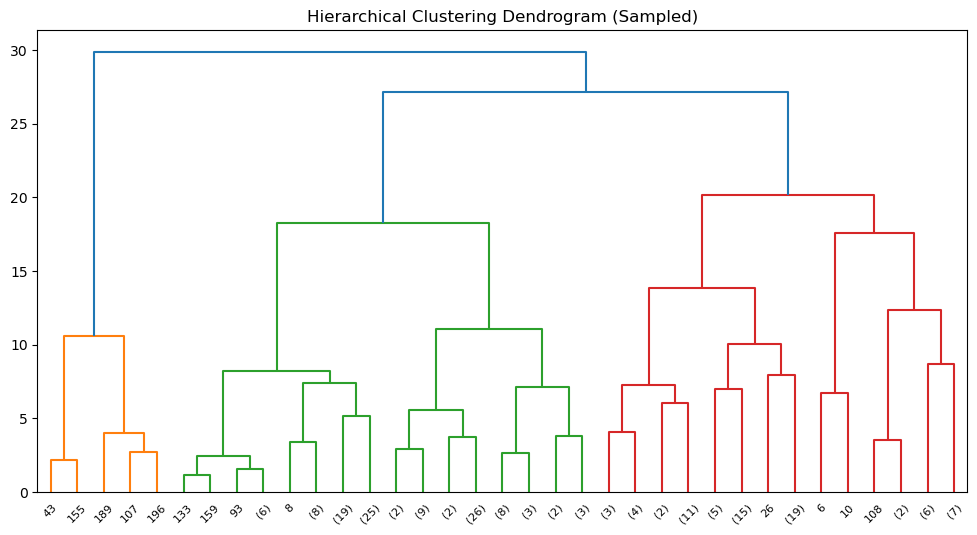

Hierarchical Silhouette Score: 0.21818887194803396


In [35]:
# Sample 200 rows for dendrogram (to avoid long computation)
sample_df = df_scaled.sample(n=200,replace=True, random_state=42)
linked = linkage(sample_df, method="ward")
plt.figure(figsize=(12,6))
dendrogram(linked, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram (Sampled)")
plt.show()

hier = AgglomerativeClustering(n_clusters=5, linkage="ward")
hier_labels = hier.fit_predict(df_scaled)
print("Hierarchical Silhouette Score:", silhouette_score(df_scaled, hier_labels))

DBSCAN

In [36]:
dbscan = DBSCAN(eps=2.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)

if len(set(dbscan_labels)) > 1:
    print("DBSCAN Silhouette Score:", silhouette_score(df_scaled, dbscan_labels))
else:
    print("DBSCAN produced only one cluster (no valid silhouette score)")

DBSCAN Silhouette Score: 0.5130379159611992


Cluster Distribution

In [37]:
print("\nCluster counts (KMeans):")
print(pd.Series(kmeans_labels).value_counts())

print("\nCluster counts (Hierarchical):")
print(pd.Series(hier_labels).value_counts())

print("\nCluster counts (DBSCAN):")
print(pd.Series(dbscan_labels).value_counts())


Cluster counts (KMeans):
1    1532
0    1297
3    1016
2     139
4      15
Name: count, dtype: int64

Cluster counts (Hierarchical):
0    2075
1    1800
2      63
3      43
4      18
Name: count, dtype: int64

Cluster counts (DBSCAN):
 0    3849
-1     115
 1      23
 2      12
Name: count, dtype: int64


In [38]:
# Example Cluster Analysis Insights for Airline Customer Dataset

# K-MEANS CLUSTERING INSIGHTS
# Cluster 0: Customers with high Balance but low recent flight activity – may be inactive high-value accounts
# Cluster 1: Customers with low Balance and low miles/transactions – likely new or inactive users
# Cluster 2: Customers with moderate Bonus_miles and Bonus_trans – active reward program participants
# Cluster 3: Customers with high Flight_miles_12mo and Flight_trans_12 – frequent flyers

# HIERARCHICAL CLUSTERING INSIGHTS
# Cluster 0: Similar to K-Means Cluster 1 – low activity and low balance
# Cluster 1: Similar to K-Means Cluster 2 – medium activity and moderate rewards
# Cluster 2: High Balance and high flight activity – VIP segment
# Dendrogram shows clear separation between inactive, moderate, and highly active users

# DBSCAN CLUSTERING INSIGHTS
# Core clusters identify dense groups of similar users:
# Cluster 0: Typical customers with moderate Balance and Bonus_miles
# Cluster 1: VIPs or very active users
# Noise points (-1): Outliers such as extremely high Balance or unusual flight patterns
# DBSCAN is useful for detecting anomalies like inactive users with high balances

# Overall Insights:
# - Balance, Bonus_miles, and Flight_miles_12mo are the main differentiators
# - K-Means and Hierarchical cluster users by activity and value
# - DBSCAN highlights outliers, such as unusual reward activity or very high balances
# - Marketing strategies: target VIPs for premium offers, moderate users for upselling, low-activity users for engagement campaigns


In [41]:
X = df[['Balance', 'Bonus_miles']].values

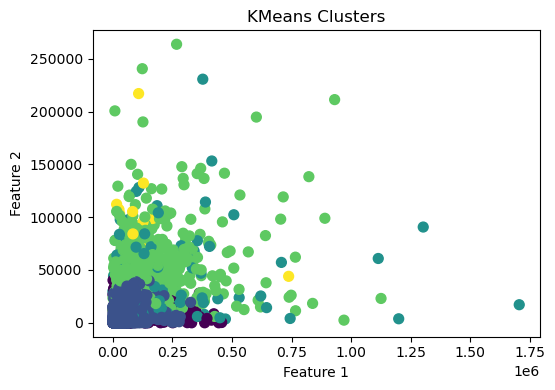

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
# KMeans scatter plot
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('KMeans Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')


plt.tight_layout()
plt.show()


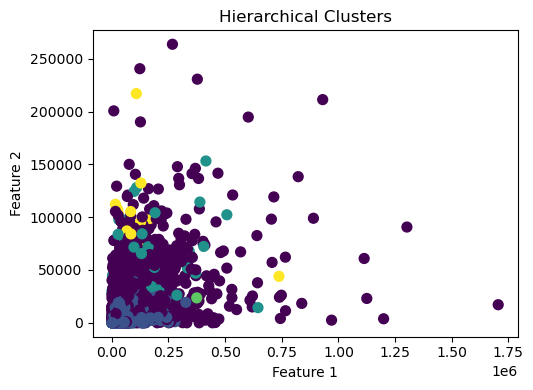

In [55]:
plt.figure(figsize=(15,4))
# Hierarchical scatter plot
plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], X[:, 1], c=hier_labels, cmap='viridis', s=50)
plt.title('Hierarchical Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()



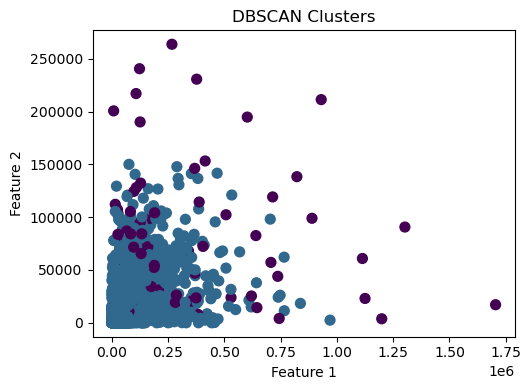

In [56]:
plt.figure(figsize=(15,4 ))
# DBSCAN scatter plot
plt.subplot(1, 3, 3)
plt.scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.title('DBSCAN Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()
